Analysis for Dataset 1:

- [www.bbci.de/competition/iv/desc_1.html](https://www.bbci.de/competition/iv/desc_1.html)

In [1]:
import os
import numpy as np
import scipy.io as sio
from scipy.signal import butter, filtfilt
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import sklearn.utils.validation
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from pyrcn.echo_state_network import ESNRegressor
from pyrcn.base.blocks import InputToNode, NodeToNode

## Data exploration

In [2]:
BASE_DIR = 'data'
DATA_DIR = os.path.join(BASE_DIR, 'BCICIV_1_mat')
LABELS_DIR = os.path.join(BASE_DIR, 'true_labels')

print(f"Base dir: {BASE_DIR}")
print(f"Signal dir: {DATA_DIR}")
print(f"Labels dir: {LABELS_DIR}")

sub = 'g' # patient a, b, c, d, e, f, g

calib_file = os.path.join(DATA_DIR, f'BCICIV_calib_ds1{sub}.mat')
eval_file = os.path.join(DATA_DIR, f'BCICIV_eval_ds1{sub}.mat')
labels_file = os.path.join(LABELS_DIR, f'BCICIV_eval_ds1{sub}_1000Hz_true_y.mat')

Base dir: data
Signal dir: data/BCICIV_1_mat
Labels dir: data/true_labels


In [3]:
def inspect_mat_file(filepath, description):
    print()
    print(f"[{description}]")
    print(f"Path: {filepath}")
    
    if not os.path.exists(filepath):
        print(f"Error: File not found at {filepath}")
        return None

    try:
        mat = sio.loadmat(filepath)
    except Exception as e:
        print(f"Error loading .mat file: {e}")
        return None
    
    keys = [key for key in mat.keys() if not key.startswith('__')]
    print(f"Keys: {keys}")
    
    for key in keys:
        val = mat[key]
        
        # Continuous Signal
        if key == 'cnt':
            print(f" - '{key}': EEG Signal | Samples: {val.shape[0]} | Channels: {val.shape[1]} | Type: {val.dtype}")
        
        # Frequency Info
        elif key == 'nfo':
            try:
                fs = val[0,0]['fs'][0,0]
                classes = val[0,0]['classes']
                print(f" - '{key}': Sampling Rate: {fs} Hz | Classes: {classes}")
            except:
                print(f" - '{key}': Info structure detected")

        # Markers
        elif key == 'mrk':
            try:
                pos = val[0,0]['pos']
                y = val[0,0]['y']
                print(f" - '{key}': Markers | Count: {pos.shape[0] if len(pos.shape)>0 else 0} | Unique classes: {np.unique(y)}")
            except:
                print(f" - '{key}': Marker structure detected")
        
        # True Test Labels
        elif key == 'true_y':
            print(f" - '{key}': True Labels | Shape: {val.shape}")

    return mat


# Calibration Data
mat_calib = inspect_mat_file(calib_file, "Calibration Data")

# # Evaluation Data (Signal)
mat_eval = inspect_mat_file(eval_file, "Evaluation Data")

# # True Test Labels
mat_labels = inspect_mat_file(labels_file, "True Test Labels")


[Calibration Data]
Path: data/BCICIV_1_mat/BCICIV_calib_ds1g.mat
Keys: ['mrk', 'cnt', 'nfo']
 - 'mrk': Markers | Count: 1 | Unique classes: [-1  1]
 - 'cnt': EEG Signal | Samples: 190602 | Channels: 59 | Type: int16
 - 'nfo': Sampling Rate: 100 Hz | Classes: [[array(['left'], dtype='<U4') array(['right'], dtype='<U5')]]

[Evaluation Data]
Path: data/BCICIV_1_mat/BCICIV_eval_ds1g.mat
Keys: ['cnt', 'nfo']
 - 'cnt': EEG Signal | Samples: 243502 | Channels: 59 | Type: int16
 - 'nfo': Sampling Rate: 100 Hz | Classes: [[array(['left'], dtype='<U4') array(['right'], dtype='<U5')]]

[True Test Labels]
Path: data/true_labels/BCICIV_eval_ds1g_1000Hz_true_y.mat
Keys: ['true_y']
 - 'true_y': True Labels | Shape: (2435020, 1)


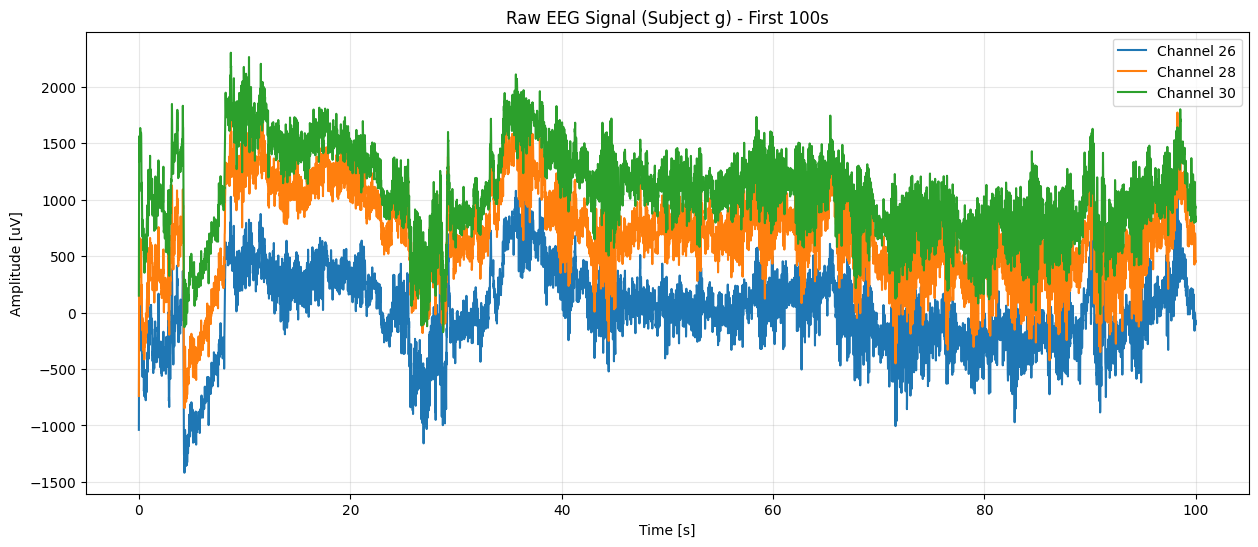

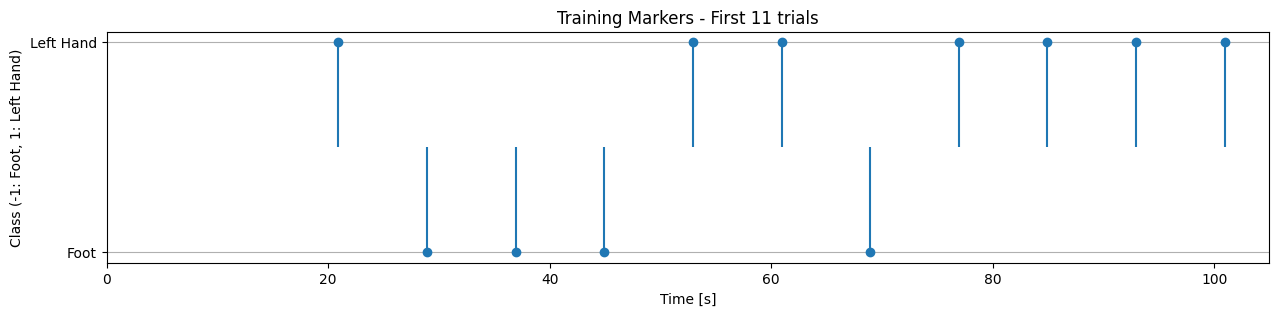

In [4]:
fs = 100  # Sampling frequency 100Hz

# Raw EEG Signal (first n seconds)
channels_to_plot = [26, 28, 30]
duration_sec = 100
samples_to_plot = duration_sec * fs

time_axis = np.arange(samples_to_plot) / fs
plt.figure(figsize=(15, 6))

for i, ch in enumerate(channels_to_plot):
    plt.plot(time_axis, mat_calib['cnt'][:samples_to_plot, ch] - np.mean(mat_calib['cnt'][:, ch]) + i*500, label=f'Channel {ch}')

plt.title(f'Raw EEG Signal (Subject {sub}) - First {duration_sec}s')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude [uV]')
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)
plt.show()

# Training Markers, when the patient was imagining movement
# 'pos' are indices where cues happened
train_pos = mat_calib['mrk'][0,0]['pos'].flatten()
train_y = mat_calib['mrk'][0,0]['y'].flatten()
limit = 11
plt.figure(figsize=(15, 3))
plt.stem(train_pos[:limit] / fs, train_y[:limit], basefmt=" ")
plt.title(f'Training Markers - First {limit} trials')
plt.xlabel('Time [s]')
plt.ylabel('Class (-1: Foot, 1: Left Hand)')
plt.yticks([-1, 1], ['Foot', 'Left Hand'])
plt.grid(True, axis='y')
plt.xlim(0)
plt.show()

## Define data loading and target creation functions


- load_bci_data: Loads .mat files and downsamples labels
- create_continuous_target: Converts markers into continuous time-series signal. Assuming that the movement imagination takes 4 seconds.

In [5]:
def load_bci_data(subject):
    f_calib = os.path.join(DATA_DIR, f'BCICIV_calib_ds1{subject}.mat')
    f_eval = os.path.join(DATA_DIR, f'BCICIV_eval_ds1{subject}.mat')
    f_labels = os.path.join(LABELS_DIR, f'BCICIV_eval_ds1{subject}_1000Hz_true_y.mat')
    
    mat_calib = sio.loadmat(f_calib)
    X_train_raw = mat_calib['cnt'].astype(np.float64) 
    mrk_pos = mat_calib['mrk'][0,0]['pos'].flatten()
    mrk_y = mat_calib['mrk'][0,0]['y'].flatten()
    fs = mat_calib['nfo'][0,0]['fs'][0,0]
    
    mat_eval = sio.loadmat(f_eval)
    X_test_raw = mat_eval['cnt'].astype(np.float64)
    
    mat_labels = sio.loadmat(f_labels)
    y_test_1000hz = mat_labels['true_y'].flatten()
    
    y_test = y_test_1000hz[::10]
    
    min_len = min(len(X_test_raw), len(y_test))
    X_test_raw = X_test_raw[:min_len]
    y_test = y_test[:min_len]
    
    print(f"Subject {subject}: Data loaded.")
    print(f"X_train shape: {X_train_raw.shape}")
    print(f"X_test shape: {X_test_raw.shape}")
    
    return X_train_raw, mrk_pos, mrk_y, X_test_raw, y_test, fs


def create_continuous_target(n_samples, pos, y, fs, duration_sec=4.0, start_offset_sec=0.5):
    target = np.zeros(n_samples)
    
    duration_samples = int(duration_sec * fs)
    offset_samples = int(start_offset_sec * fs)
    
    for p, label in zip(pos, y):
        start = min(p + offset_samples, n_samples)
        end = min(start + duration_samples, n_samples)
        target[start:end] = label
        
    return target

- Continuous target creation - example

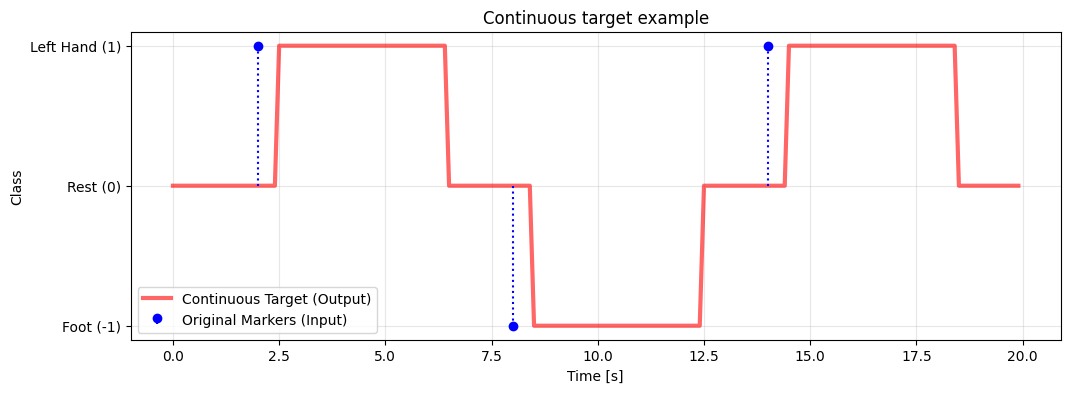

In [6]:
fs_example = 10
duration_total_sec = 20
n_samples_example = duration_total_sec * fs_example
pos_example = np.array([20, 80, 140])
y_example = np.array([1, -1, 1])

target_continuous_example = create_continuous_target(
    n_samples=n_samples_example, 
    pos=pos_example, 
    y=y_example, 
    fs=fs_example, 
    duration_sec=4.0 # assuming that each movement imagination lasts 4 seconds
)

time_axis_example = np.arange(n_samples_example) / fs_example
plt.figure(figsize=(12, 4))
plt.plot(time_axis_example, target_continuous_example, 'r-', linewidth=3, alpha=0.6, label='Continuous Target (Output)')
plt.stem(pos_example / fs_example, y_example, linefmt='b:', markerfmt='bo', basefmt=" ", label='Original Markers (Input)')
plt.title("Continuous target example")
plt.xlabel("Time [s]")
plt.ylabel("Class")
plt.yticks([-1, 0, 1], ['Foot (-1)', 'Rest (0)', 'Left Hand (1)'])
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

## Define signal processing functions

- preprocess_signal: Bandpass filtering (8-30Hz)
- extract_log_variance_features: Moving window log-variance extraction

In [7]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs # Nyquist freq - max possible freq to save when sampling fs (50% of fs according to Shannona theorem)
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')

    # filter coeffs - numerator b and denominator a polynomials
    return b, a


def preprocess_signal(data, lowcut=8.0, highcut=30.0, fs=100.0):
    b, a = butter_bandpass(lowcut, highcut, fs, order=4)
    # Filtering with zero phase shift
    # filtering from left to right, and then from right to left
    y = filtfilt(b, a, data, axis=0)
    return y


def extract_log_variance_features(data, window_size=100):
    # changing volts to energy
    power = np.square(data) # temp energy approx
    window = np.ones(window_size) / window_size
    
    # smoothing energy using moving average to extract power trend
    feat_list = []
    for i in range(data.shape[1]):
        smooth_power = np.convolve(power[:, i], window, mode='same')
        feat_list.append(smooth_power)
        
    features = np.column_stack(feat_list)
    return np.log(features + 1e-6) # converting skewed distr to Gaussian

## Execute data loading and processing pipeline

- Load data for patient (subject)
- Clean NaNs from raw data
- Apply bandpass filter and feature extraction
- Clean NaNs from extracted features

In [8]:
subjects = ['a', 'b', 'c', 'd', 'e', 'f', 'g']
all_X_train_feats = []
all_y_train = []

subject_test_data = {}

for subject in subjects:
    X_train_raw, pos, y_class, X_test_raw, y_test, fs = load_bci_data(subject)

    X_train_raw = np.nan_to_num(X_train_raw, nan=0.0, posinf=0.0, neginf=0.0)
    X_test_raw = np.nan_to_num(X_test_raw, nan=0.0, posinf=0.0, neginf=0.0)

    y_train = create_continuous_target(len(X_train_raw), pos, y_class, fs, duration_sec=4.0)

    X_train_proc = preprocess_signal(X_train_raw, fs=fs)
    X_test_proc = preprocess_signal(X_test_raw, fs=fs)

    X_train_feats = extract_log_variance_features(X_train_proc, window_size=100)
    X_test_feats = extract_log_variance_features(X_test_proc, window_size=100)

    X_train_feats = np.nan_to_num(X_train_feats, nan=0.0, posinf=0.0, neginf=0.0)
    X_test_feats = np.nan_to_num(X_test_feats, nan=0.0, posinf=0.0, neginf=0.0)

    all_X_train_feats.append(X_train_feats)
    all_y_train.append(y_train)

    subject_test_data[subject] = {
        'X_test_feats': X_test_feats,
        'y_test': y_test,
        'fs': fs
    }

X_train_all = np.concatenate(all_X_train_feats)
y_train_all = np.concatenate(all_y_train)

n_features = X_train_all.shape[1]
print(f"Combined input shape: {X_train_all.shape}")

Subject a: Data loaded.
X_train shape: (190594, 59)
X_test shape: (240558, 59)
Subject b: Data loaded.
X_train shape: (190594, 59)
X_test shape: (246970, 59)
Subject c: Data loaded.
X_train shape: (190549, 59)
X_test shape: (233364, 59)
Subject d: Data loaded.
X_train shape: (190473, 59)
X_test shape: (245093, 59)
Subject e: Data loaded.
X_train shape: (190329, 59)
X_test shape: (238450, 59)
Subject f: Data loaded.
X_train shape: (190608, 59)
X_test shape: (239226, 59)
Subject g: Data loaded.
X_train shape: (190602, 59)
X_test shape: (243502, 59)
Combined input shape: (1333749, 59)


## Initialize and Train ESN Model

- Manually generate input weights
- Define ESN layers (Input, Reservoir with leakage, Readout)
- Train the model

In [11]:
hidden_size = 500 # TODO: experiment with bigger hidden size
k_in = 10 

rng = np.random.RandomState(0)
W_in = np.zeros((n_features, hidden_size))

for j in range(hidden_size):
    indices = rng.choice(n_features, k_in, replace=False)
    weights = rng.uniform(-0.1, 0.1, k_in)
    W_in[indices, j] = weights

input_to_node = InputToNode(
    hidden_layer_size=hidden_size,
    input_activation='identity',
    predefined_input_weights=W_in,
    bias_scaling=0.0
)

node_to_node = NodeToNode(
    hidden_layer_size=hidden_size,
    spectral_radius=0.9,
    leakage=0.1,
    reservoir_activation='tanh',
    bidirectional=False
)

regressor = Ridge(alpha=1e-3)

esn = ESNRegressor(
    input_to_node=input_to_node,
    node_to_node=node_to_node,
    regressor=regressor
)

esn.fit(X_train_all, y_train_all)

ESNRegressor(input_to_node=InputToNode(bias_scaling=0.0,
                                       input_activation='identity',
                                       predefined_input_weights=array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.08423152,  0.        , ...,  0.        ,
        -0.07902402,  0.        ],
       [-0.01001   ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
        -0.09796325,  0.        ],
       [ 0.        , -0.0833775 ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]], shape=(59, 500))),
             node_to_node=NodeToNode(leakage=0.1, spectral_radius=0.9),
             regressor=Ridge(alpha=0.001), requires_sequence=False)

## Prediction and Evaluation

In [12]:
y_pred_continuous = esn.predict(X_test_feats)

y_pred_continuous = np.nan_to_num(y_pred_continuous, nan=0.0)
y_test = np.nan_to_num(y_test, nan=0.0)

mse = mean_squared_error(y_test, y_pred_continuous)
print(f"MSE result for subject {subject}: {mse:.4f}")

MSE result for subject g: 0.3624


## Visualizations

- segment of True Labels vs ESN Prediction
- histogram of predicted values

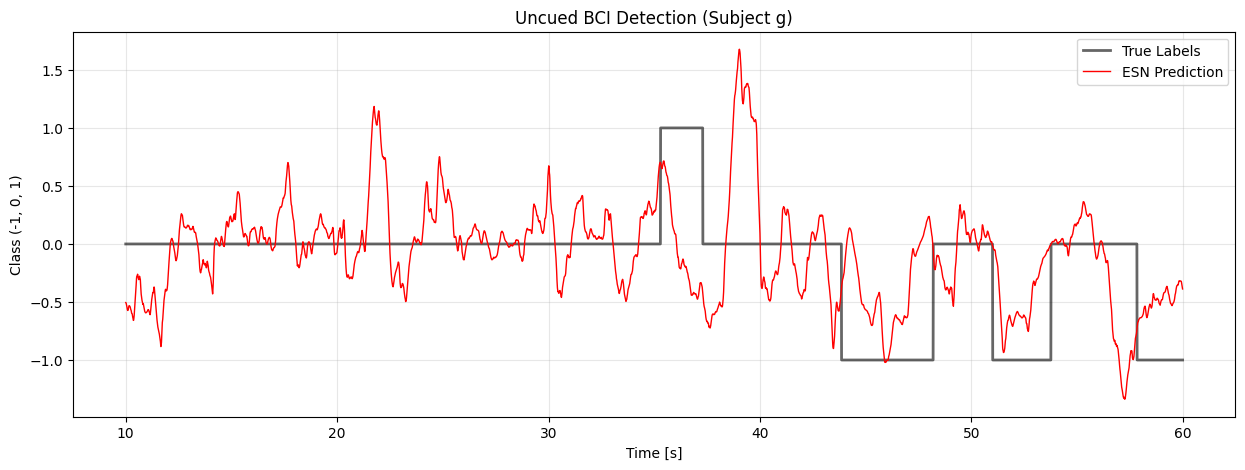

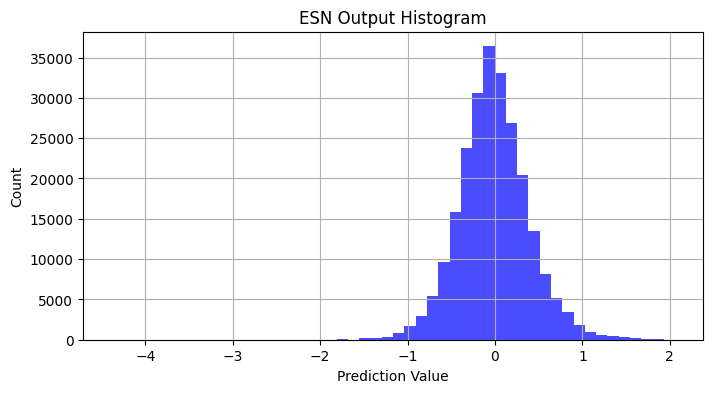

In [ ]:
plt.figure(figsize=(15, 5))
samples_to_show = 5000 
start_sample = 1000

t = np.arange(start_sample, start_sample + samples_to_show) / fs

plt.plot(t, y_test[start_sample:start_sample+samples_to_show], 'k-', label='True Labels', linewidth=2, alpha=0.6)
plt.plot(t, y_pred_continuous[start_sample:start_sample+samples_to_show], 'r-', label='ESN Prediction', linewidth=1)

plt.title(f'Uncued BCI Detection (Subject {subject})')
plt.xlabel('Time [s]')
plt.ylabel('Class (-1, 0, 1)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

plt.figure(figsize=(8, 4))
plt.hist(y_pred_continuous, bins=50, color='blue', alpha=0.7)
plt.title('ESN Output Histogram')
plt.xlabel('Prediction Value')
plt.ylabel('Count')
plt.grid(True)
plt.show()

### Show BCI Detection per subject


--- Evaluating Subject a ---
MSE result for subject a: 0.3618


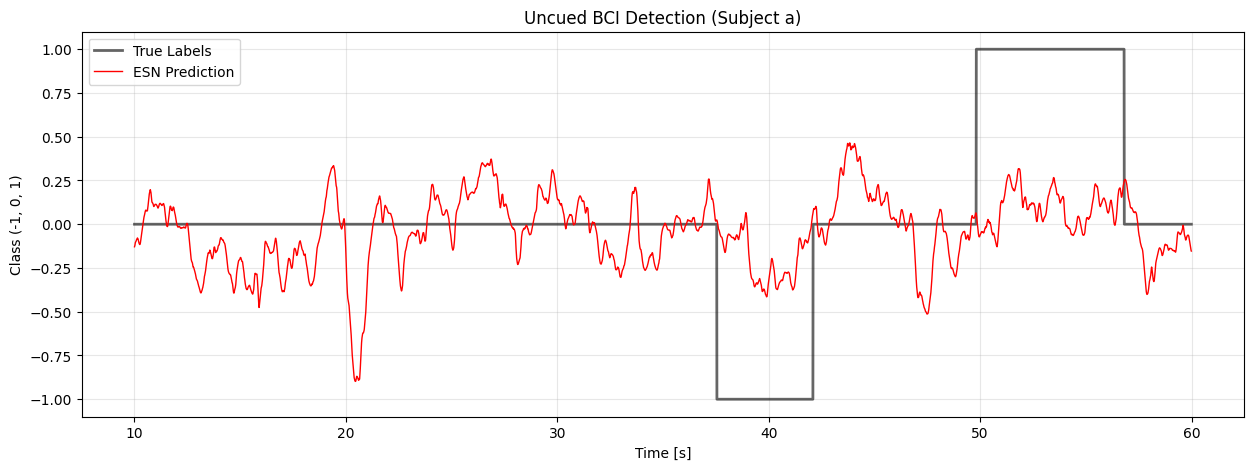

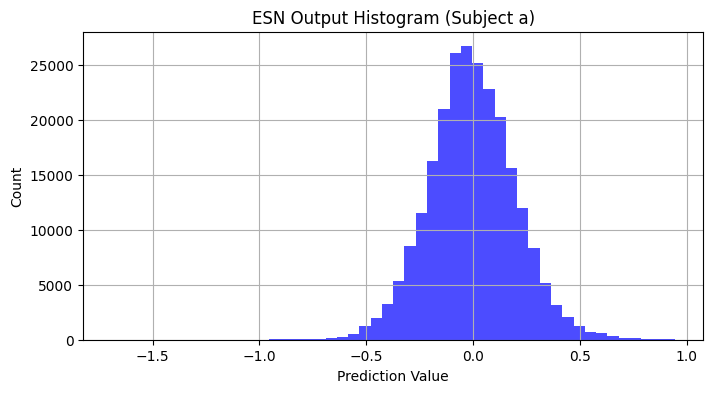


--- Evaluating Subject b ---
MSE result for subject b: 0.4109


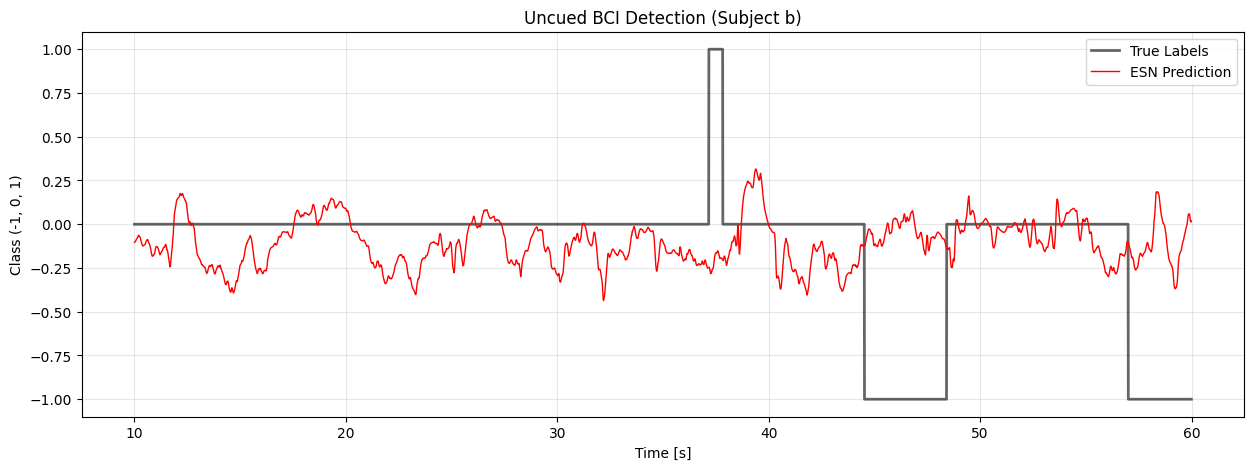

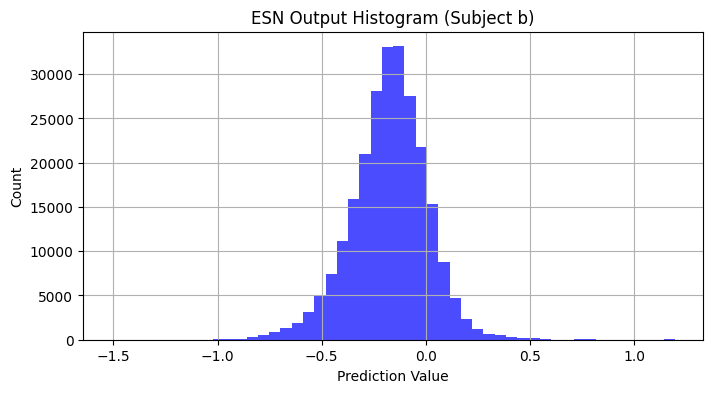


--- Evaluating Subject c ---
MSE result for subject c: 7.3978


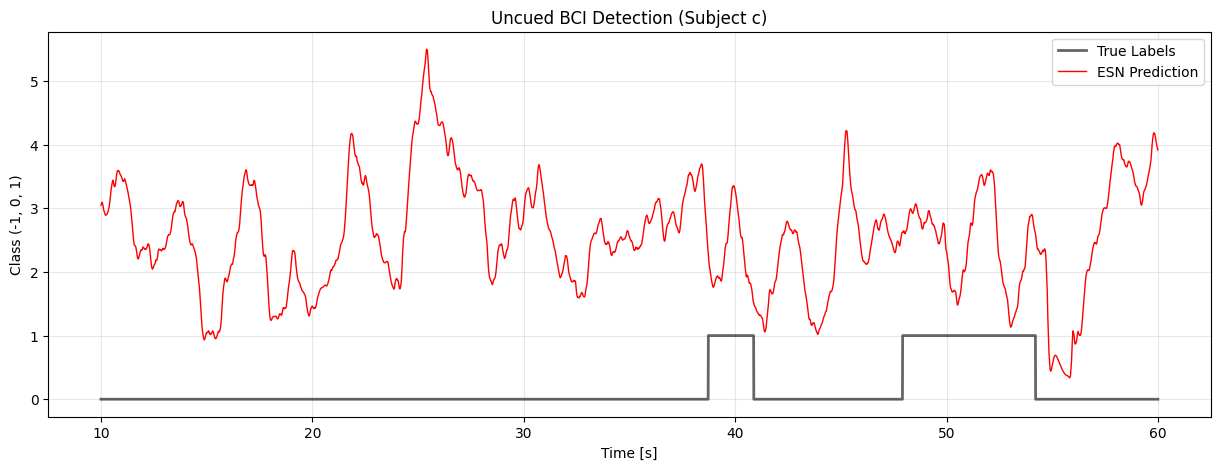

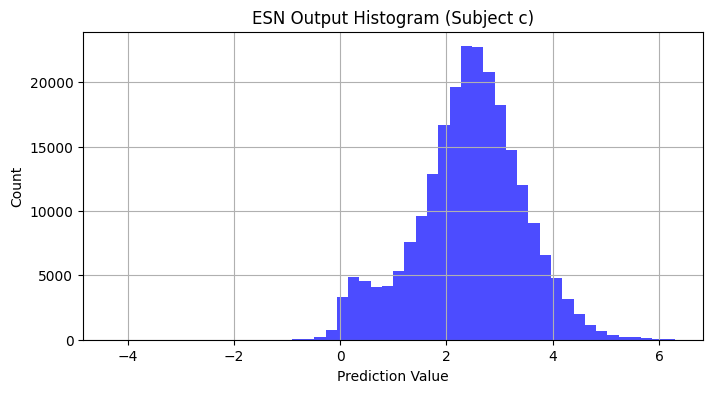


--- Evaluating Subject d ---
MSE result for subject d: 2.4802


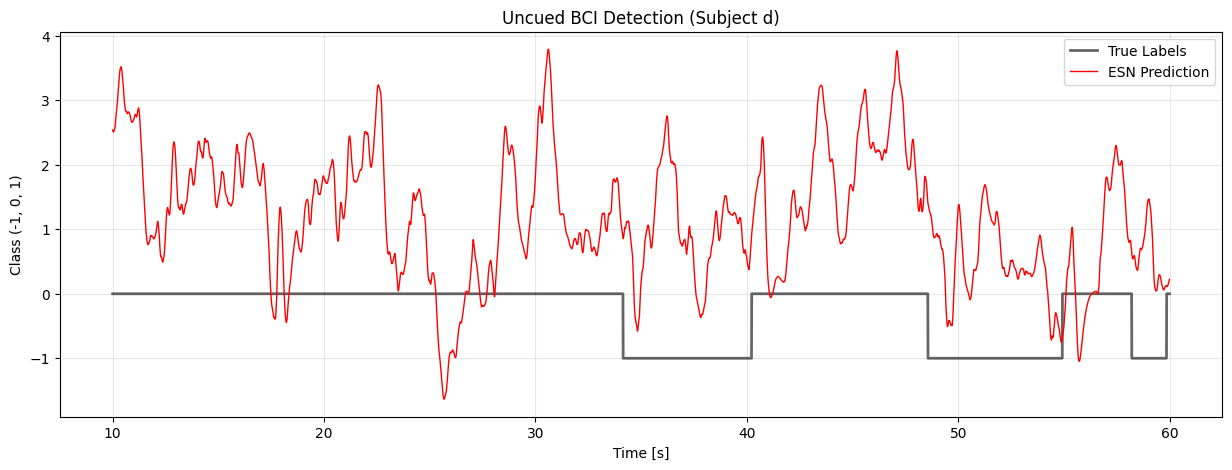

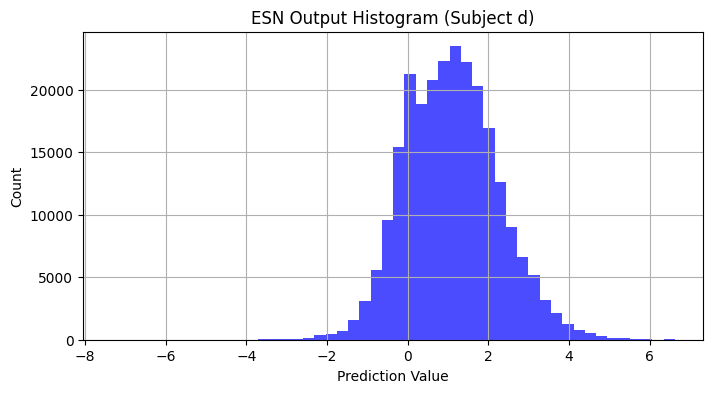


--- Evaluating Subject e ---
MSE result for subject e: 0.3097


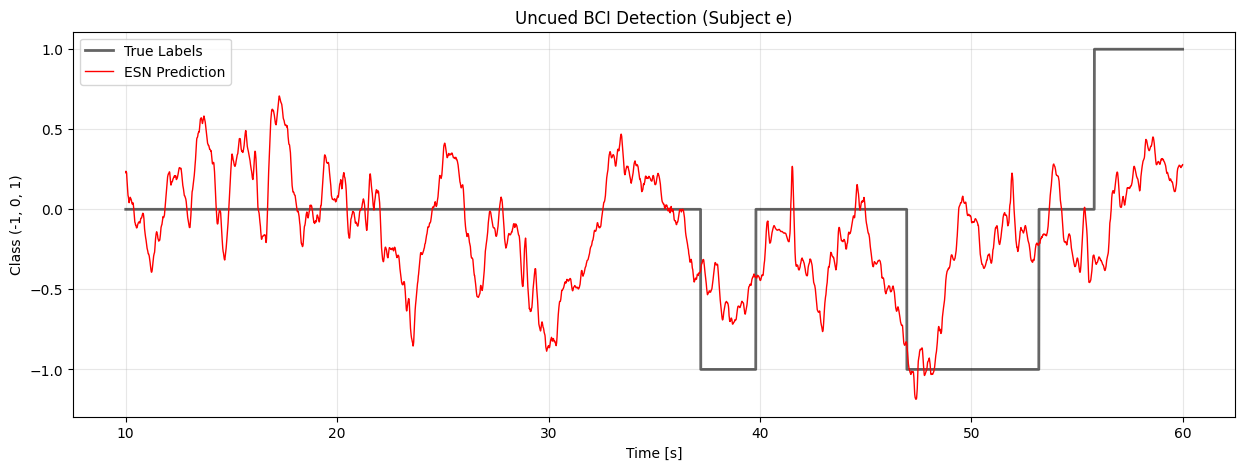

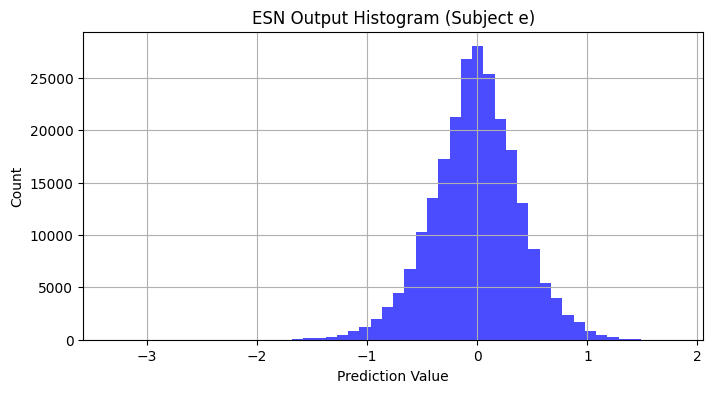


--- Evaluating Subject f ---
MSE result for subject f: 0.3852


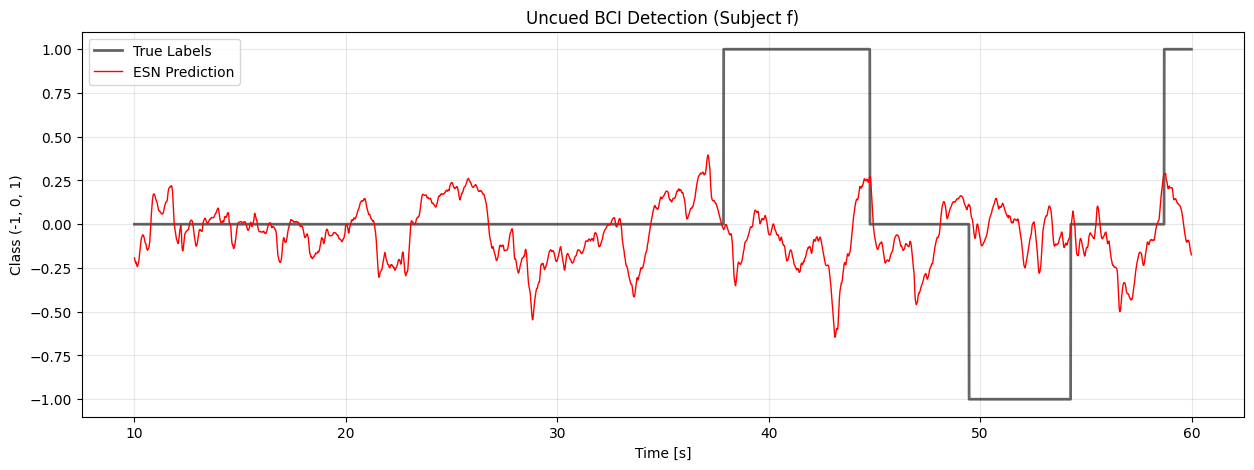

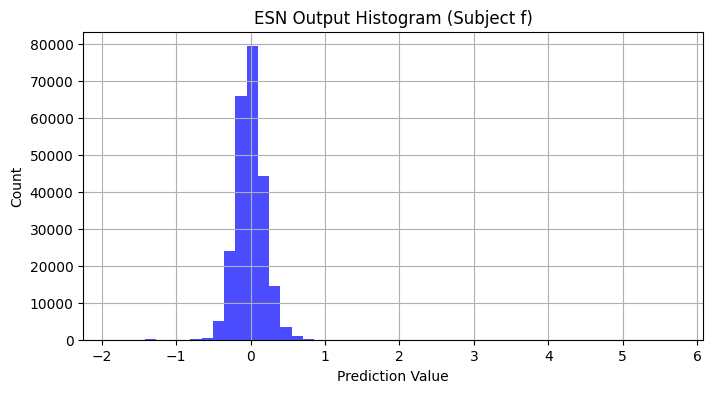


--- Evaluating Subject g ---
MSE result for subject g: 0.3624


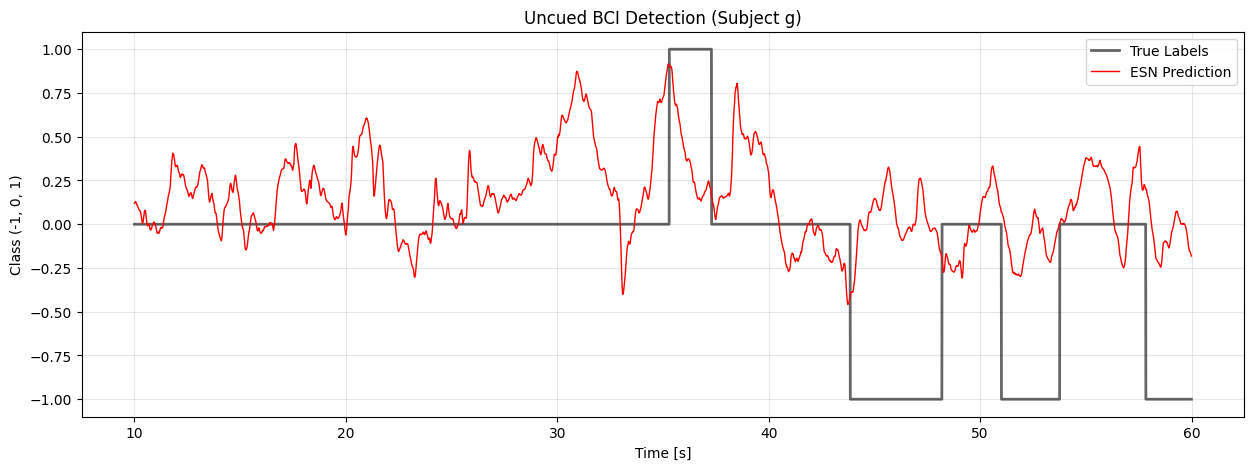

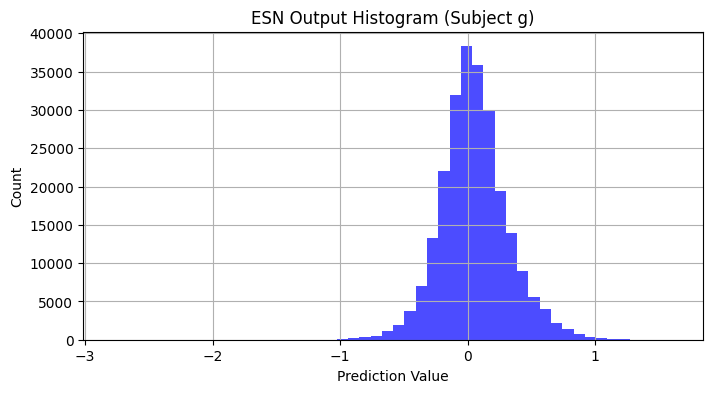

In [17]:
for subject in subjects:
    print(f"\n--- Evaluating Subject {subject} ---")
    
    data = subject_test_data[subject]
    X_test_feats = data['X_test_feats']
    y_test = np.nan_to_num(data['y_test'], nan=0.0)
    fs = data['fs']

    y_pred_continuous = esn.predict(X_test_feats)
    y_pred_continuous = np.nan_to_num(y_pred_continuous, nan=0.0)

    mse = mean_squared_error(y_test, y_pred_continuous)
    print(f"MSE result for subject {subject}: {mse:.4f}")

    plt.figure(figsize=(15, 5))
    samples_to_show = 5000 
    start_sample = 1000
    
    end_sample = min(start_sample + samples_to_show, len(y_test))
    
    if start_sample < end_sample:
        t = np.arange(start_sample, end_sample) / fs
        
        plt.plot(t, y_test[start_sample:end_sample], 'k-', label='True Labels', linewidth=2, alpha=0.6)
        plt.plot(t, y_pred_continuous[start_sample:end_sample], 'r-', label='ESN Prediction', linewidth=1)

        plt.title(f'Uncued BCI Detection (Subject {subject})')
        plt.xlabel('Time [s]')
        plt.ylabel('Class (-1, 0, 1)')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()
    else:
        print(f"Not enough samples to plot for subject {subject}")

    plt.figure(figsize=(8, 4))
    plt.hist(y_pred_continuous, bins=50, color='blue', alpha=0.7)
    plt.title(f'ESN Output Histogram (Subject {subject})')
    plt.xlabel('Prediction Value')
    plt.ylabel('Count')
    plt.grid(True)
    plt.show()

## Hyperparameter optimization

In [ ]:
import numpy as np
import gc

subjects_metadata = [] 
all_X_train_feats = []

for subject in subjects:
    X_train_raw, pos, y_class, X_test_raw, y_test, fs = load_bci_data(subject)

    X_train_raw = np.nan_to_num(X_train_raw, nan=0.0)
    X_train_proc = preprocess_signal(X_train_raw, fs=fs)
    X_train_feats = extract_log_variance_features(X_train_proc, window_size=100)
    X_train_feats = np.nan_to_num(X_train_feats, nan=0.0)

    all_X_train_feats.append(X_train_feats.astype(np.float32))

    subjects_metadata.append({
        'n_samples': len(X_train_feats),
        'pos': pos,
        'y_class': y_class,
        'fs': fs
    })

X_full_static = np.concatenate(all_X_train_feats).astype(np.float32)

STRIDE = 10
X_opt_static = X_full_static[::STRIDE]

print(f"Dane X gotowe. Kształt dla Optuny: {X_opt_static.shape}")

Subject a: Data loaded.
X_train shape: (190594, 59)
X_test shape: (240558, 59)
Subject b: Data loaded.
X_train shape: (190594, 59)
X_test shape: (246970, 59)
Subject c: Data loaded.
X_train shape: (190549, 59)
X_test shape: (233364, 59)
Subject d: Data loaded.
X_train shape: (190473, 59)
X_test shape: (245093, 59)
Subject e: Data loaded.
X_train shape: (190329, 59)
X_test shape: (238450, 59)
Subject f: Data loaded.
X_train shape: (190608, 59)
X_test shape: (239226, 59)
Subject g: Data loaded.
X_train shape: (190602, 59)
X_test shape: (243502, 59)
Dane X gotowe. Kształt dla Optuny: (133375, 59)


In [11]:
import optuna
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from pyrcn.echo_state_network import ESNRegressor
from pyrcn.base.blocks import InputToNode, NodeToNode
import joblib

def objective(trial):
    offset_sec = trial.suggest_float('target_offset', 0.0, 1.0)
    duration_sec = trial.suggest_float('target_duration', 2.0, 4.0)
    
    y_list = []
    for meta in subjects_metadata:
        y_sub = create_continuous_target(
            n_samples=meta['n_samples'],
            pos=meta['pos'],
            y=meta['y_class'],
            fs=meta['fs'],
            duration_sec=duration_sec,
            start_offset_sec=offset_sec
        )
        y_list.append(y_sub)

    y_full_dynamic = np.concatenate(y_list).astype(np.float32)
    y_opt_dynamic = y_full_dynamic[::STRIDE]
    
    X_train, X_val, y_train, y_val = train_test_split(
        X_opt_static, y_opt_dynamic, test_size=0.2, random_state=42, shuffle=False
    )
    
    n_features = X_train.shape[1]

    reservoir_activation = trial.suggest_categorical('reservoir_activation', ['tanh', 'identity'])
    
    if reservoir_activation == 'identity':
        spectral_radius = trial.suggest_float('sr_identity', 0.1, 0.95)
    else:
        spectral_radius = trial.suggest_float('sr_tanh', 0.1, 1.5)

    hidden_size = trial.suggest_int('hidden_size', 200, 1500, step=100)
    k_in = trial.suggest_int('k_in', 1, 20)
    leakage = trial.suggest_float('leakage', 0.01, 1.0)
    bias_scaling = trial.suggest_float('bias_scaling', 0.0, 1.0)

    regressor_type = trial.suggest_categorical('regressor', ['Ridge', 'Lasso'])
    if regressor_type == 'Ridge':
        alpha = trial.suggest_float('ridge_alpha', 1e-4, 10.0, log=True)
        regressor = Ridge(alpha=alpha)
    else:
        alpha = trial.suggest_float('lasso_alpha', 1e-4, 1.0, log=True)
        regressor = Lasso(alpha=alpha)

    rng = np.random.RandomState(0) 
    W_in = np.zeros((n_features, hidden_size), dtype=np.float32)
    
    for j in range(hidden_size):
        curr_k = min(k_in, n_features)
        indices = rng.choice(n_features, curr_k, replace=False)
        weights = rng.uniform(-0.1, 0.1, curr_k).astype(np.float32)
        W_in[indices, j] = weights

    input_to_node = InputToNode(
        hidden_layer_size=hidden_size,
        input_activation='identity',
        predefined_input_weights=W_in,
        bias_scaling=bias_scaling
    )

    node_to_node = NodeToNode(
        hidden_layer_size=hidden_size,
        spectral_radius=spectral_radius,
        leakage=leakage,
        reservoir_activation=reservoir_activation,
        bidirectional=False
    )

    esn = ESNRegressor(
        input_to_node=input_to_node,
        node_to_node=node_to_node,
        regressor=regressor
    )

    try:
        with joblib.parallel_backend('loky', n_jobs=1):
            esn.fit(X_train, y_train)
            y_pred = esn.predict(X_val)
            
            if np.isnan(y_pred).any():
                raise ValueError("NaNs in prediction")
                
            mse = mean_squared_error(y_val, y_pred)
            
    except Exception as e:
        print(f"Trial failed: {e}")
        return float('inf')
    
    finally:
        del esn
        if 'y_pred' in locals(): del y_pred
        gc.collect()

    return mse


if __name__ == "__main__":
    study = optuna.create_study(direction='minimize')
    
    study.optimize(objective, n_trials=50, show_progress_bar=True, n_jobs=1)

    print("\n--- Best params ---")
    print(study.best_params)

[I 2025-12-10 18:21:53,268] A new study created in memory with name: no-name-f2975695-331b-4143-b05d-ca00d629446a


  0%|          | 0/50 [00:00<?, ?it/s]

/Users/jkbstepien/Developer/data-science/semester-2/Reservoir-Computing-for-Brain-Computer-Interface-Decoding/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.203e+02, tolerance: 3.211e+00
  model = cd_fast.enet_coordinate_descent(


[I 2025-12-10 18:22:01,383] Trial 0 finished with value: 0.28576216346948374 and parameters: {'target_offset': 0.727661694578232, 'target_duration': 2.863350957783793, 'reservoir_activation': 'identity', 'sr_identity': 0.6464269435869766, 'hidden_size': 500, 'k_in': 4, 'leakage': 0.7504537846115608, 'bias_scaling': 0.9015184530931877, 'regressor': 'Lasso', 'lasso_alpha': 0.00021878154535518875}. Best is trial 0 with value: 0.28576216346948374.
[I 2025-12-10 18:22:12,364] Trial 1 finished with value: 0.7175088423866212 and parameters: {'target_offset': 0.3643887327755475, 'target_duration': 3.705086691595412, 'reservoir_activation': 'tanh', 'sr_tanh': 0.2233034326735521, 'hidden_size': 1300, 'k_in': 16, 'leakage': 0.18024135492767066, 'bias_scaling': 0.420530400503753, 'regressor': 'Ridge', 'ridge_alpha': 0.025911888557468545}. Best is trial 0 with value: 0.28576216346948374.
[I 2025-12-10 18:22:22,021] Trial 2 finished with value: 0.24393371254422086 and parameters: {'target_offset': 0

/Users/jkbstepien/Developer/data-science/semester-2/Reservoir-Computing-for-Brain-Computer-Interface-Decoding/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.602e+03, tolerance: 2.484e+00
  model = cd_fast.enet_coordinate_descent(


[I 2025-12-10 18:23:02,007] Trial 6 finished with value: 0.2233650555064163 and parameters: {'target_offset': 0.4837566239282224, 'target_duration': 2.228723673995967, 'reservoir_activation': 'identity', 'sr_identity': 0.8801429520833937, 'hidden_size': 1200, 'k_in': 10, 'leakage': 0.7822843059739593, 'bias_scaling': 0.3642893360049516, 'regressor': 'Lasso', 'lasso_alpha': 0.0001230748306781067}. Best is trial 6 with value: 0.2233650555064163.


/Users/jkbstepien/Developer/data-science/semester-2/Reservoir-Computing-for-Brain-Computer-Interface-Decoding/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.421e+01, tolerance: 2.427e+00
  model = cd_fast.enet_coordinate_descent(


[I 2025-12-10 18:23:14,723] Trial 7 finished with value: 0.22156293915914826 and parameters: {'target_offset': 0.4288373494886102, 'target_duration': 2.166123691917484, 'reservoir_activation': 'tanh', 'sr_tanh': 0.33034449268692784, 'hidden_size': 800, 'k_in': 7, 'leakage': 0.6981716269332763, 'bias_scaling': 0.2914801290548529, 'regressor': 'Lasso', 'lasso_alpha': 0.00019171008120825756}. Best is trial 7 with value: 0.22156293915914826.
[I 2025-12-10 18:23:15,561] Trial 8 finished with value: 0.37768744129278586 and parameters: {'target_offset': 0.1963446280692207, 'target_duration': 3.822427823776281, 'reservoir_activation': 'identity', 'sr_identity': 0.2743730672301004, 'hidden_size': 200, 'k_in': 10, 'leakage': 0.4654953648742674, 'bias_scaling': 0.02506224979867233, 'regressor': 'Ridge', 'ridge_alpha': 0.077136436117539}. Best is trial 7 with value: 0.22156293915914826.
[I 2025-12-10 18:23:16,654] Trial 9 finished with value: 0.3140888887934176 and parameters: {'target_offset': 0.

/Users/jkbstepien/Developer/data-science/semester-2/Reservoir-Computing-for-Brain-Computer-Interface-Decoding/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.126e+03, tolerance: 2.238e+00
  model = cd_fast.enet_coordinate_descent(


[I 2025-12-10 18:23:32,635] Trial 11 finished with value: 0.2041299197306695 and parameters: {'target_offset': 0.48109973914846366, 'target_duration': 2.0094787725074874, 'reservoir_activation': 'tanh', 'sr_tanh': 1.4570601306058881, 'hidden_size': 800, 'k_in': 7, 'leakage': 0.9639592718414209, 'bias_scaling': 0.3356788859314979, 'regressor': 'Lasso', 'lasso_alpha': 0.00014102965265678225}. Best is trial 11 with value: 0.2041299197306695.
[I 2025-12-10 18:23:36,069] Trial 12 finished with value: 0.21433855407438993 and parameters: {'target_offset': 0.5259248660635861, 'target_duration': 2.0403414023181345, 'reservoir_activation': 'tanh', 'sr_tanh': 1.4735819490149573, 'hidden_size': 800, 'k_in': 6, 'leakage': 0.9828910189540632, 'bias_scaling': 0.2800642869430412, 'regressor': 'Lasso', 'lasso_alpha': 0.0011592732879193179}. Best is trial 11 with value: 0.2041299197306695.
[I 2025-12-10 18:23:38,521] Trial 13 finished with value: 0.21166736788849072 and parameters: {'target_offset': 0.6

/Users/jkbstepien/Developer/data-science/semester-2/Reservoir-Computing-for-Brain-Computer-Interface-Decoding/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.471e+00, tolerance: 3.794e+00
  model = cd_fast.enet_coordinate_descent(


[I 2025-12-10 18:25:45,195] Trial 19 finished with value: 0.3396470717047003 and parameters: {'target_offset': 0.34677602718994816, 'target_duration': 3.380930372622869, 'reservoir_activation': 'tanh', 'sr_tanh': 0.8833028363485531, 'hidden_size': 1500, 'k_in': 13, 'leakage': 0.8695830119659792, 'bias_scaling': 0.7423886701913308, 'regressor': 'Lasso', 'lasso_alpha': 0.0004818738158701206}. Best is trial 11 with value: 0.2041299197306695.
[I 2025-12-10 18:25:50,006] Trial 20 finished with value: 0.2720269424649689 and parameters: {'target_offset': 0.9833621136575609, 'target_duration': 2.596368810154388, 'reservoir_activation': 'tanh', 'sr_tanh': 1.2709454713688704, 'hidden_size': 1000, 'k_in': 16, 'leakage': 0.8645164865922702, 'bias_scaling': 0.514969732144608, 'regressor': 'Lasso', 'lasso_alpha': 0.008081054676231141}. Best is trial 11 with value: 0.2041299197306695.
[I 2025-12-10 18:25:52,618] Trial 21 finished with value: 0.21267933655924642 and parameters: {'target_offset': 0.591

/Users/jkbstepien/Developer/data-science/semester-2/Reservoir-Computing-for-Brain-Computer-Interface-Decoding/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.676e+02, tolerance: 2.486e+00
  model = cd_fast.enet_coordinate_descent(


[I 2025-12-10 18:26:23,558] Trial 24 finished with value: 0.226396809835322 and parameters: {'target_offset': 0.46216229920810165, 'target_duration': 2.224125274250661, 'reservoir_activation': 'tanh', 'sr_tanh': 0.849271918468052, 'hidden_size': 1000, 'k_in': 16, 'leakage': 0.8062101169986094, 'bias_scaling': 0.14035349227176086, 'regressor': 'Lasso', 'lasso_alpha': 0.00010819709506053961}. Best is trial 11 with value: 0.2041299197306695.
[I 2025-12-10 18:26:33,271] Trial 25 finished with value: 0.22316301076341713 and parameters: {'target_offset': 0.27200190420448356, 'target_duration': 2.1850369959996527, 'reservoir_activation': 'tanh', 'sr_tanh': 0.609055867769696, 'hidden_size': 900, 'k_in': 8, 'leakage': 0.91238946568624, 'bias_scaling': 0.4907028698276962, 'regressor': 'Lasso', 'lasso_alpha': 0.0003090832333381793}. Best is trial 11 with value: 0.2041299197306695.
[I 2025-12-10 18:26:50,644] Trial 26 finished with value: 0.25833365907452754 and parameters: {'target_offset': 0.517

/Users/jkbstepien/Developer/data-science/semester-2/Reservoir-Computing-for-Brain-Computer-Interface-Decoding/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.492e+01, tolerance: 3.238e+00
  model = cd_fast.enet_coordinate_descent(


[I 2025-12-10 18:27:11,559] Trial 28 finished with value: 0.2905599527423926 and parameters: {'target_offset': 0.5421264683752057, 'target_duration': 2.890815032234704, 'reservoir_activation': 'tanh', 'sr_tanh': 1.302544843131827, 'hidden_size': 1100, 'k_in': 9, 'leakage': 0.809108777179101, 'bias_scaling': 0.6950027478122205, 'regressor': 'Lasso', 'lasso_alpha': 0.00043939842278507965}. Best is trial 11 with value: 0.2041299197306695.
[I 2025-12-10 18:27:15,826] Trial 29 finished with value: 0.3061465202562344 and parameters: {'target_offset': 0.6671171060242176, 'target_duration': 2.916404407803201, 'reservoir_activation': 'tanh', 'sr_tanh': 0.9577697060367775, 'hidden_size': 900, 'k_in': 12, 'leakage': 0.7538713425115282, 'bias_scaling': 0.45270993127567966, 'regressor': 'Lasso', 'lasso_alpha': 0.04393065833611836}. Best is trial 11 with value: 0.2041299197306695.


/Users/jkbstepien/Developer/data-science/semester-2/Reservoir-Computing-for-Brain-Computer-Interface-Decoding/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.106e+03, tolerance: 2.797e+00
  model = cd_fast.enet_coordinate_descent(


[I 2025-12-10 18:27:28,219] Trial 30 finished with value: 0.2552353888976374 and parameters: {'target_offset': 0.6988048576240329, 'target_duration': 2.5029264076001225, 'reservoir_activation': 'tanh', 'sr_tanh': 0.7132377478081466, 'hidden_size': 700, 'k_in': 18, 'leakage': 0.46960707942758445, 'bias_scaling': 0.5551706776737982, 'regressor': 'Lasso', 'lasso_alpha': 0.00010007621543481273}. Best is trial 11 with value: 0.2041299197306695.
[I 2025-12-10 18:27:33,359] Trial 31 finished with value: 0.20657983998544965 and parameters: {'target_offset': 0.7976945190137816, 'target_duration': 2.0013183510476065, 'reservoir_activation': 'tanh', 'sr_tanh': 1.3655282149938055, 'hidden_size': 700, 'k_in': 12, 'leakage': 0.9956021224540816, 'bias_scaling': 0.22081262262649853, 'regressor': 'Lasso', 'lasso_alpha': 0.0008034496861502684}. Best is trial 11 with value: 0.2041299197306695.


/Users/jkbstepien/Developer/data-science/semester-2/Reservoir-Computing-for-Brain-Computer-Interface-Decoding/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.577e+00, tolerance: 2.356e+00
  model = cd_fast.enet_coordinate_descent(


[I 2025-12-10 18:27:41,764] Trial 32 finished with value: 0.21535078180582234 and parameters: {'target_offset': 0.5725020091912483, 'target_duration': 2.116257261748919, 'reservoir_activation': 'tanh', 'sr_tanh': 1.1643373150007525, 'hidden_size': 500, 'k_in': 12, 'leakage': 0.9272884855015567, 'bias_scaling': 0.3933354284103442, 'regressor': 'Lasso', 'lasso_alpha': 0.000283397021883959}. Best is trial 11 with value: 0.2041299197306695.
[I 2025-12-10 18:27:45,370] Trial 33 finished with value: 0.239662014638945 and parameters: {'target_offset': 0.44819693324509613, 'target_duration': 2.303373122124199, 'reservoir_activation': 'tanh', 'sr_tanh': 1.3810864750566525, 'hidden_size': 700, 'k_in': 14, 'leakage': 0.8341947109481178, 'bias_scaling': 0.3043401439418101, 'regressor': 'Lasso', 'lasso_alpha': 0.0012688437295420797}. Best is trial 11 with value: 0.2041299197306695.
[I 2025-12-10 18:27:53,495] Trial 34 finished with value: 0.37949125309859827 and parameters: {'target_offset': 0.2952

/Users/jkbstepien/Developer/data-science/semester-2/Reservoir-Computing-for-Brain-Computer-Interface-Decoding/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.091e+02, tolerance: 4.460e+00
  model = cd_fast.enet_coordinate_descent(


[I 2025-12-10 18:28:09,904] Trial 36 finished with value: 0.39461057228931556 and parameters: {'target_offset': 0.6403399784926553, 'target_duration': 3.973202749837829, 'reservoir_activation': 'identity', 'sr_identity': 0.42125404558519697, 'hidden_size': 900, 'k_in': 5, 'leakage': 0.30207344499648126, 'bias_scaling': 0.9495763334033092, 'regressor': 'Lasso', 'lasso_alpha': 0.0006174026948223424}. Best is trial 11 with value: 0.2041299197306695.
[I 2025-12-10 18:28:14,845] Trial 37 finished with value: 0.27022563838081975 and parameters: {'target_offset': 0.8316854399091576, 'target_duration': 2.3744908877327098, 'reservoir_activation': 'tanh', 'sr_tanh': 1.0576686734894447, 'hidden_size': 1100, 'k_in': 9, 'leakage': 0.9216602928600268, 'bias_scaling': 0.43852718241788713, 'regressor': 'Ridge', 'ridge_alpha': 2.3595341086656703}. Best is trial 11 with value: 0.2041299197306695.


/Users/jkbstepien/Developer/data-science/semester-2/Reservoir-Computing-for-Brain-Computer-Interface-Decoding/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.229e+02, tolerance: 2.366e+00
  model = cd_fast.enet_coordinate_descent(


[I 2025-12-10 18:28:44,247] Trial 38 finished with value: 0.21359557825147726 and parameters: {'target_offset': 0.39863273015294676, 'target_duration': 2.1249908612369413, 'reservoir_activation': 'identity', 'sr_identity': 0.46963980175218756, 'hidden_size': 1300, 'k_in': 14, 'leakage': 0.7661063943886919, 'bias_scaling': 0.32729349852822714, 'regressor': 'Lasso', 'lasso_alpha': 0.00022820891932699345}. Best is trial 11 with value: 0.2041299197306695.


/Users/jkbstepien/Developer/data-science/semester-2/Reservoir-Computing-for-Brain-Computer-Interface-Decoding/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.243e+02, tolerance: 2.564e+00
  model = cd_fast.enet_coordinate_descent(


[I 2025-12-10 18:29:22,704] Trial 39 finished with value: 0.23177521827934325 and parameters: {'target_offset': 0.5086558442024213, 'target_duration': 2.2976762450278865, 'reservoir_activation': 'tanh', 'sr_tanh': 1.4198805765563784, 'hidden_size': 1400, 'k_in': 17, 'leakage': 0.573972800573004, 'bias_scaling': 0.2515254128071536, 'regressor': 'Lasso', 'lasso_alpha': 0.00023372913634683826}. Best is trial 11 with value: 0.2041299197306695.
[I 2025-12-10 18:29:25,300] Trial 40 finished with value: 0.27879819328194894 and parameters: {'target_offset': 0.002942152638558848, 'target_duration': 2.7558330133857405, 'reservoir_activation': 'identity', 'sr_identity': 0.319649497078788, 'hidden_size': 700, 'k_in': 9, 'leakage': 0.9965365762134615, 'bias_scaling': 0.03106456319998155, 'regressor': 'Ridge', 'ridge_alpha': 0.004288782611844137}. Best is trial 11 with value: 0.2041299197306695.
[I 2025-12-10 18:29:29,465] Trial 41 finished with value: 0.20621340358735538 and parameters: {'target_of

/Users/jkbstepien/Developer/data-science/semester-2/Reservoir-Computing-for-Brain-Computer-Interface-Decoding/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.199e+02, tolerance: 2.238e+00
  model = cd_fast.enet_coordinate_descent(


[I 2025-12-10 18:29:45,701] Trial 45 finished with value: 0.20363958252460812 and parameters: {'target_offset': 0.8493631282766532, 'target_duration': 2.0062060530232997, 'reservoir_activation': 'tanh', 'sr_tanh': 1.2988674394170774, 'hidden_size': 400, 'k_in': 10, 'leakage': 0.9401334885158498, 'bias_scaling': 0.18234485856461444, 'regressor': 'Lasso', 'lasso_alpha': 0.0001609201874270788}. Best is trial 45 with value: 0.20363958252460812.


/Users/jkbstepien/Developer/data-science/semester-2/Reservoir-Computing-for-Brain-Computer-Interface-Decoding/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.772e+03, tolerance: 2.686e+00
  model = cd_fast.enet_coordinate_descent(


[I 2025-12-10 18:29:49,210] Trial 46 finished with value: 0.2401709625338552 and parameters: {'target_offset': 0.8771843899846652, 'target_duration': 2.4038065987684543, 'reservoir_activation': 'identity', 'sr_identity': 0.11183577623057167, 'hidden_size': 200, 'k_in': 7, 'leakage': 0.9536637969274142, 'bias_scaling': 0.4109512128247046, 'regressor': 'Lasso', 'lasso_alpha': 0.00015135212998601416}. Best is trial 45 with value: 0.20363958252460812.
[I 2025-12-10 18:29:54,801] Trial 47 finished with value: 0.22319899519945177 and parameters: {'target_offset': 0.9430420783687634, 'target_duration': 2.188785759528767, 'reservoir_activation': 'tanh', 'sr_tanh': 1.2576696397367542, 'hidden_size': 400, 'k_in': 10, 'leakage': 0.4005671219927611, 'bias_scaling': 0.17303097975133164, 'regressor': 'Lasso', 'lasso_alpha': 0.00034349491004917536}. Best is trial 45 with value: 0.20363958252460812.
[I 2025-12-10 18:29:56,026] Trial 48 finished with value: 0.3968874535346317 and parameters: {'target_o

/Users/jkbstepien/Developer/data-science/semester-2/Reservoir-Computing-for-Brain-Computer-Interface-Decoding/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.502e+02, tolerance: 2.350e+00
  model = cd_fast.enet_coordinate_descent(


[I 2025-12-10 18:30:12,715] Trial 49 finished with value: 0.2169491472233437 and parameters: {'target_offset': 0.7623701003484293, 'target_duration': 2.102829836049026, 'reservoir_activation': 'tanh', 'sr_tanh': 1.309788052803857, 'hidden_size': 1000, 'k_in': 14, 'leakage': 0.030526811578830082, 'bias_scaling': 0.049963947169696765, 'regressor': 'Lasso', 'lasso_alpha': 0.00020430373913736844}. Best is trial 45 with value: 0.20363958252460812.

--- Best params ---
{'target_offset': 0.8493631282766532, 'target_duration': 2.0062060530232997, 'reservoir_activation': 'tanh', 'sr_tanh': 1.2988674394170774, 'hidden_size': 400, 'k_in': 10, 'leakage': 0.9401334885158498, 'bias_scaling': 0.18234485856461444, 'regressor': 'Lasso', 'lasso_alpha': 0.0001609201874270788}


In [14]:
import numpy as np
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression
from pyrcn.base.blocks import InputToNode, NodeToNode
from pyrcn.echo_state_network import ESNRegressor
from pyrcn.base.blocks import InputToNode, NodeToNode

bp = study.best_params
print(f"Najlepsze parametry: {bp}")

if 'target_offset' in bp:
    print("Regeneracja wektora y (targetu) z optymalnym offsetem i czasem trwania...")
    
    y_final_list = []
    for meta in subjects_metadata:
        y_sub = create_continuous_target(
            n_samples=meta['n_samples'],
            pos=meta['pos'],
            y=meta['y_class'],
            fs=meta['fs'],
            duration_sec=bp['target_duration'],
            start_offset_sec=bp['target_offset']
        )
        y_final_list.append(y_sub)
    
    y_full_final = np.concatenate(y_final_list).astype(np.float32)
else:
    print("Używam oryginalnego y_full (bez optymalizacji targetu).")
    y_full_final = y_full

if bp['reservoir_activation'] == 'identity':
    final_spectral_radius = bp['sr_identity']
else:
    final_spectral_radius = bp['sr_tanh']

print(f"Aktywacja: {bp['reservoir_activation']}, Spectral Radius: {final_spectral_radius}")

if bp['regressor'] == 'Ridge':
    final_reg = Ridge(alpha=bp['ridge_alpha'])
elif bp['regressor'] == 'Lasso':
    final_reg = Lasso(alpha=bp['lasso_alpha'])
elif bp['regressor'] == 'ElasticNet':
    final_reg = ElasticNet(alpha=bp['en_alpha'], l1_ratio=bp['en_l1_ratio'])
else:
    final_reg = LinearRegression()
    
rng = np.random.RandomState(0)
final_hidden = bp['hidden_size']
final_k_in = bp['k_in']
n_features = X_full_static.shape[1]

W_in_final = np.zeros((n_features, final_hidden), dtype=np.float32)
for j in range(final_hidden):
    curr_k = min(final_k_in, n_features)
    idx = rng.choice(n_features, curr_k, replace=False)
    w = rng.uniform(-0.1, 0.1, curr_k).astype(np.float32)
    W_in_final[idx, j] = w

final_input_to_node = InputToNode(
    hidden_layer_size=final_hidden,
    input_activation='identity',
    predefined_input_weights=W_in_final,
    bias_scaling=bp['bias_scaling']
)

final_node_to_node = NodeToNode(
    hidden_layer_size=final_hidden,
    spectral_radius=final_spectral_radius,
    leakage=bp['leakage'],
    reservoir_activation=bp['reservoir_activation'],
    bidirectional=False
)

final_esn = ESNRegressor(
    input_to_node=final_input_to_node,
    node_to_node=final_node_to_node,
    regressor=final_reg
)

print(f"Rozpoczynam trening modelu finalnego na pełnych danych: X={X_full_static.shape}, y={y_full_final.shape}")

final_esn.fit(X_full_static, y_full_final)

print("Model finalny gotowy do predykcji!")

Najlepsze parametry: {'target_offset': 0.8493631282766532, 'target_duration': 2.0062060530232997, 'reservoir_activation': 'tanh', 'sr_tanh': 1.2988674394170774, 'hidden_size': 400, 'k_in': 10, 'leakage': 0.9401334885158498, 'bias_scaling': 0.18234485856461444, 'regressor': 'Lasso', 'lasso_alpha': 0.0001609201874270788}
Regeneracja wektora y (targetu) z optymalnym offsetem i czasem trwania...
Aktywacja: tanh, Spectral Radius: 1.2988674394170774
Rozpoczynam trening modelu finalnego na pełnych danych: X=(1333749, 59), y=(1333749,)
Model finalny gotowy do predykcji!


/Users/jkbstepien/Developer/data-science/semester-2/Reservoir-Computing-for-Brain-Computer-Interface-Decoding/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.900e+03, tolerance: 2.800e+01
  model = cd_fast.enet_coordinate_descent(



--- Evaluating Subject a ---
MSE result for subject a: 0.3693


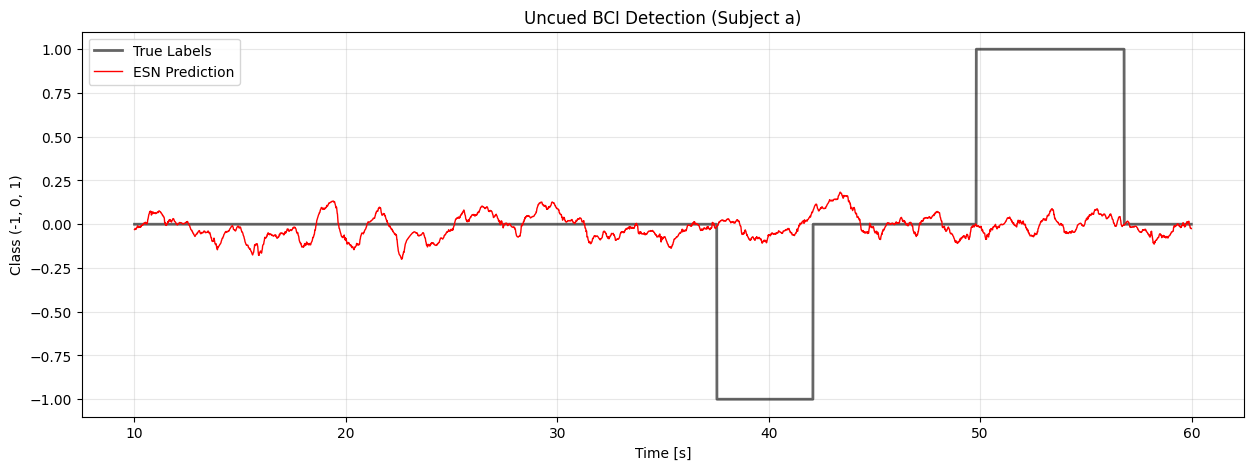

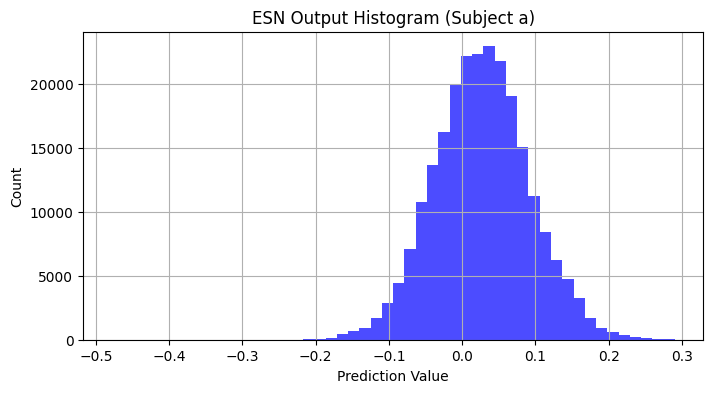


--- Evaluating Subject b ---
MSE result for subject b: 0.3797


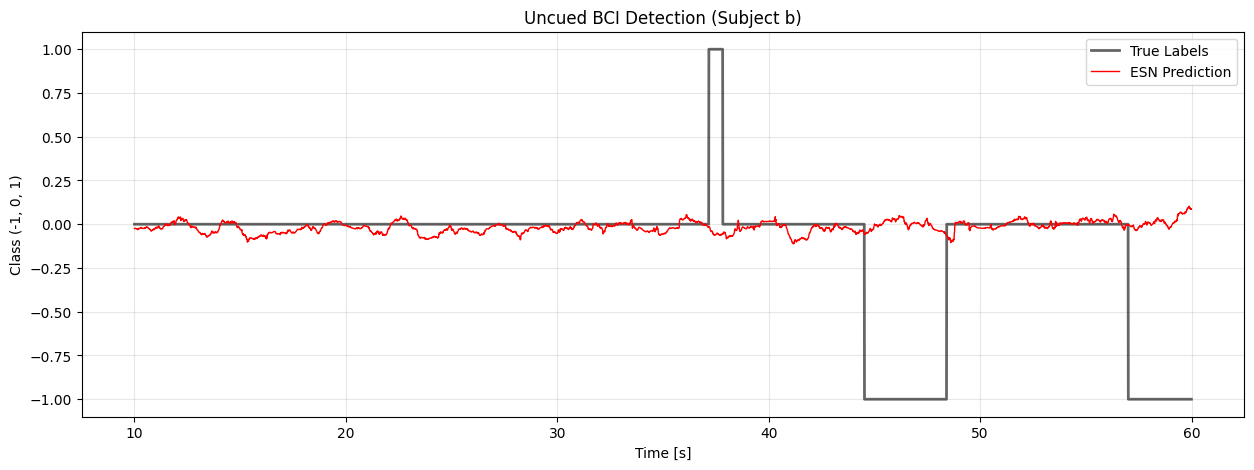

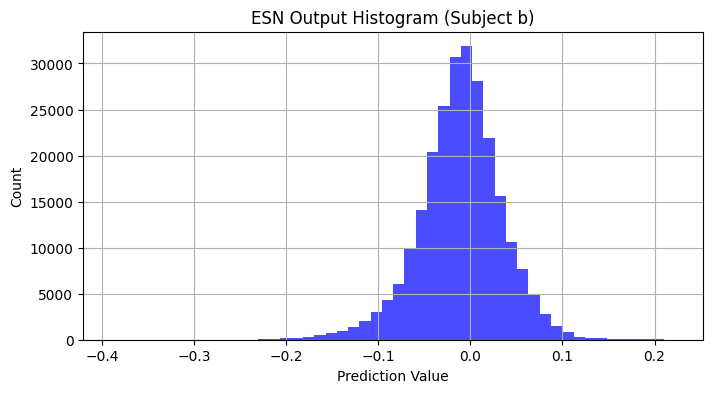


--- Evaluating Subject c ---
MSE result for subject c: 0.3862


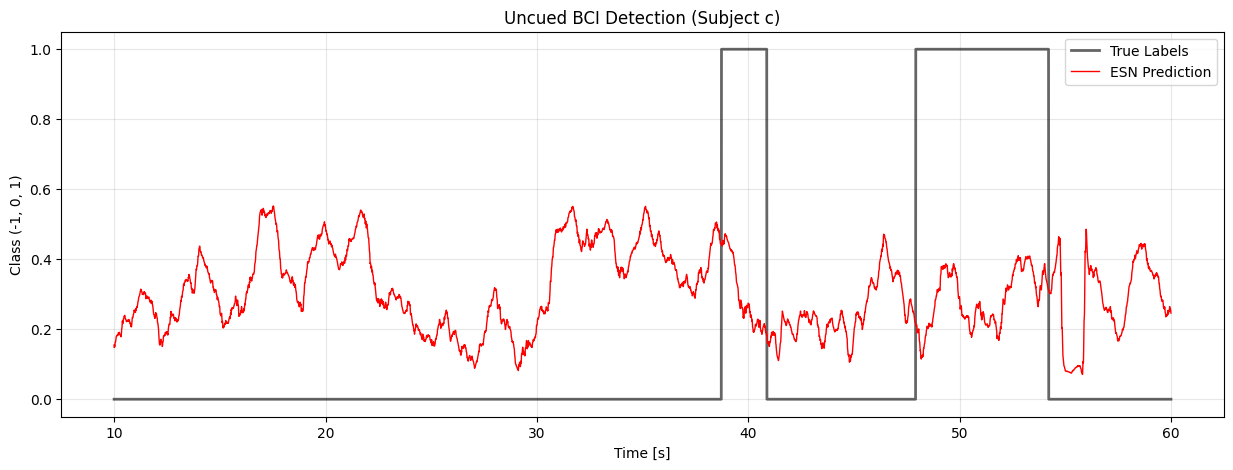

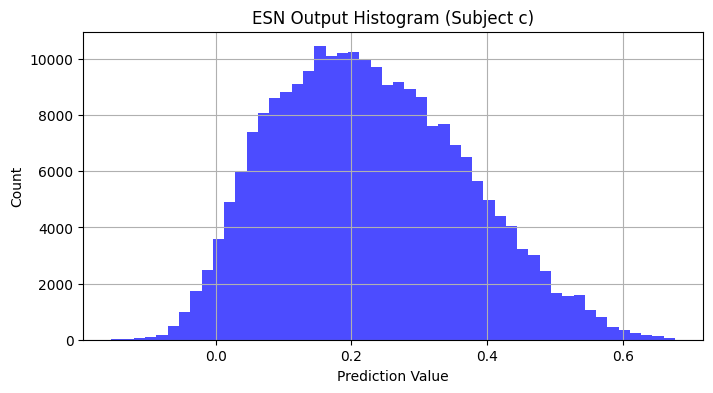


--- Evaluating Subject d ---
MSE result for subject d: 0.3318


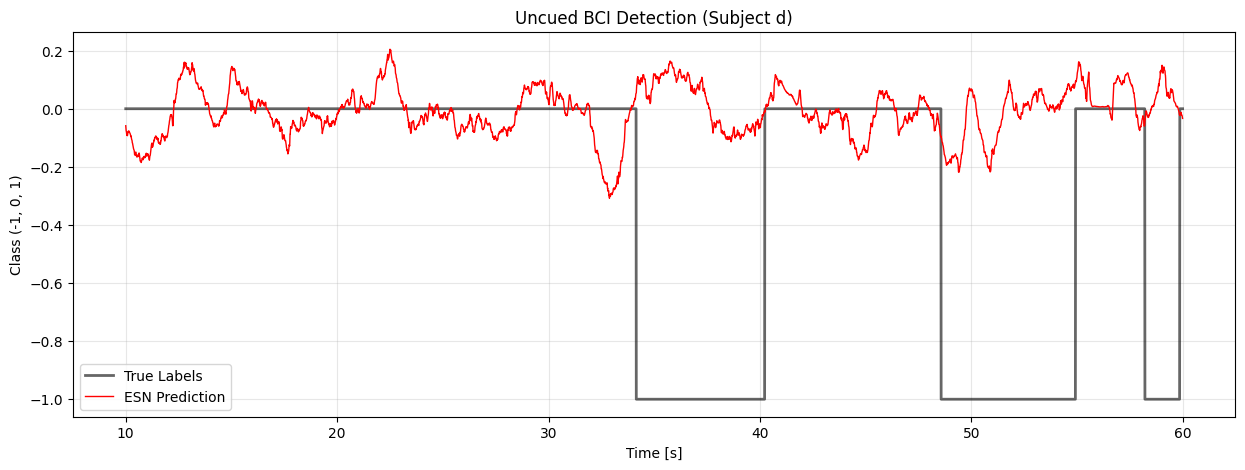

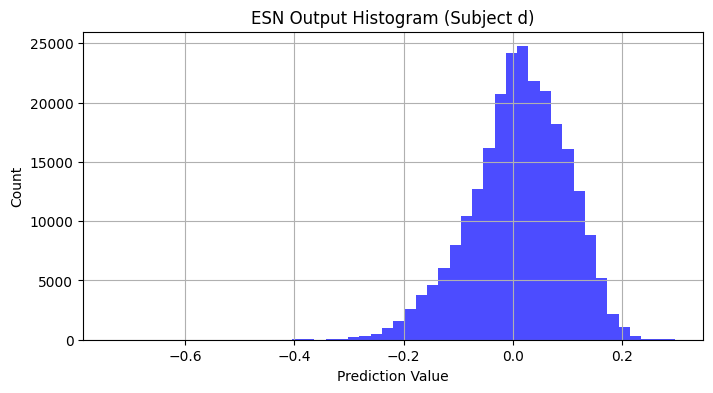


--- Evaluating Subject e ---
MSE result for subject e: 0.3369


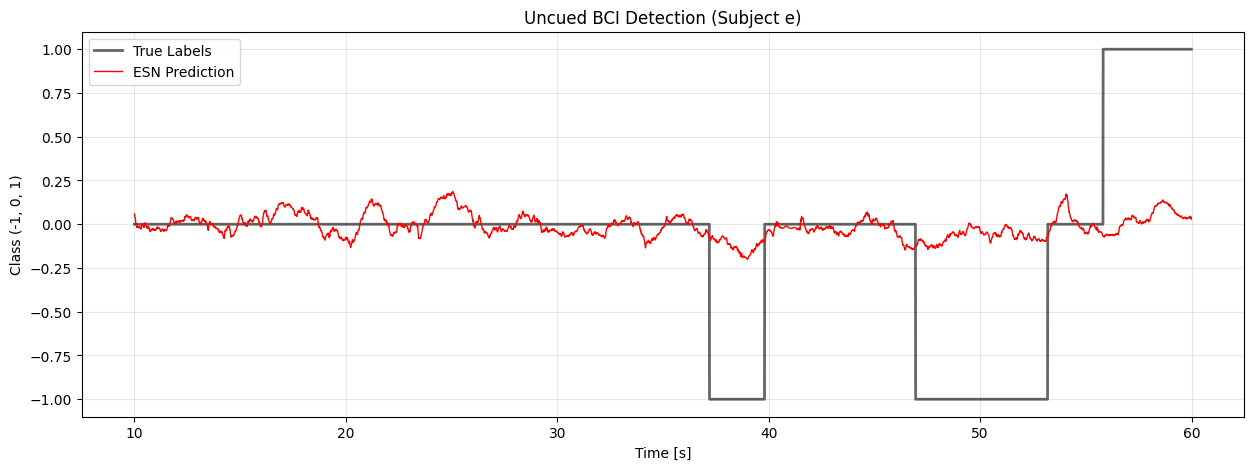

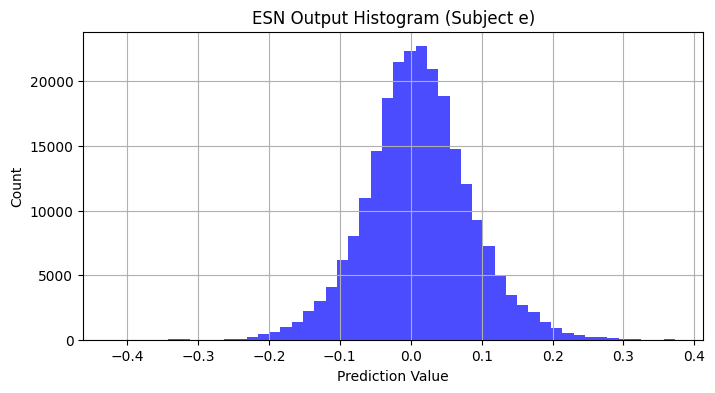


--- Evaluating Subject f ---
MSE result for subject f: 0.3591


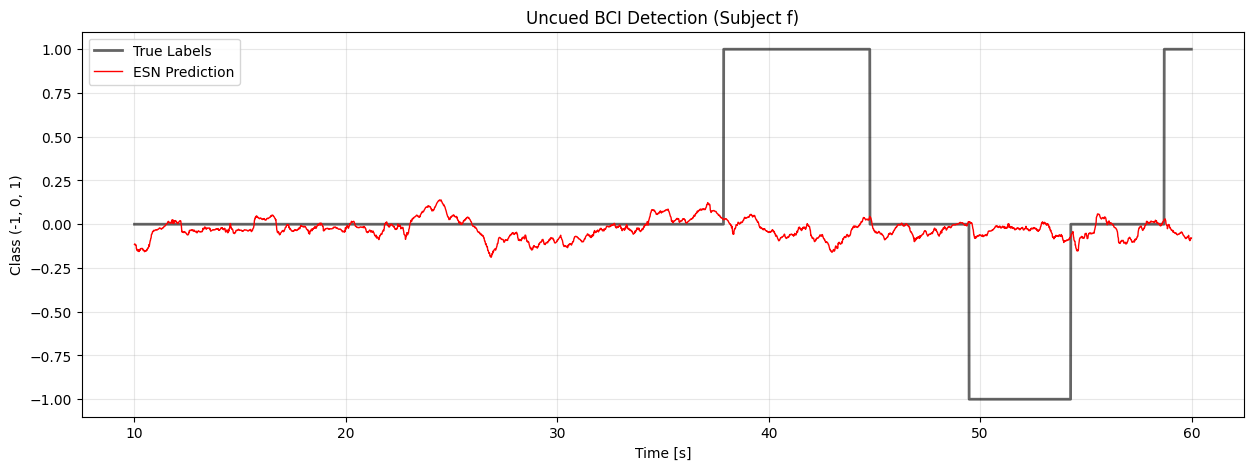

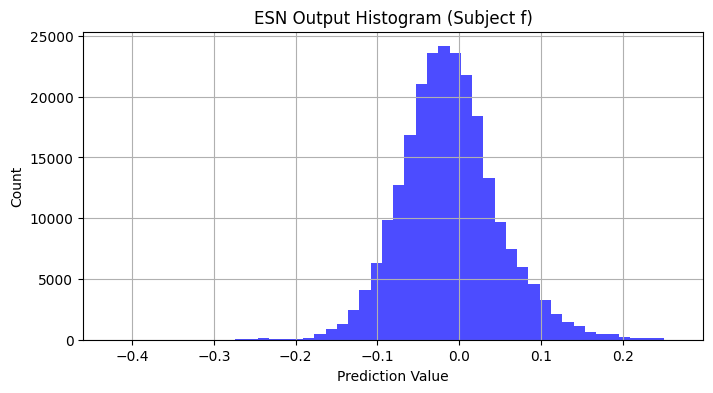


--- Evaluating Subject g ---
MSE result for subject g: 0.3694


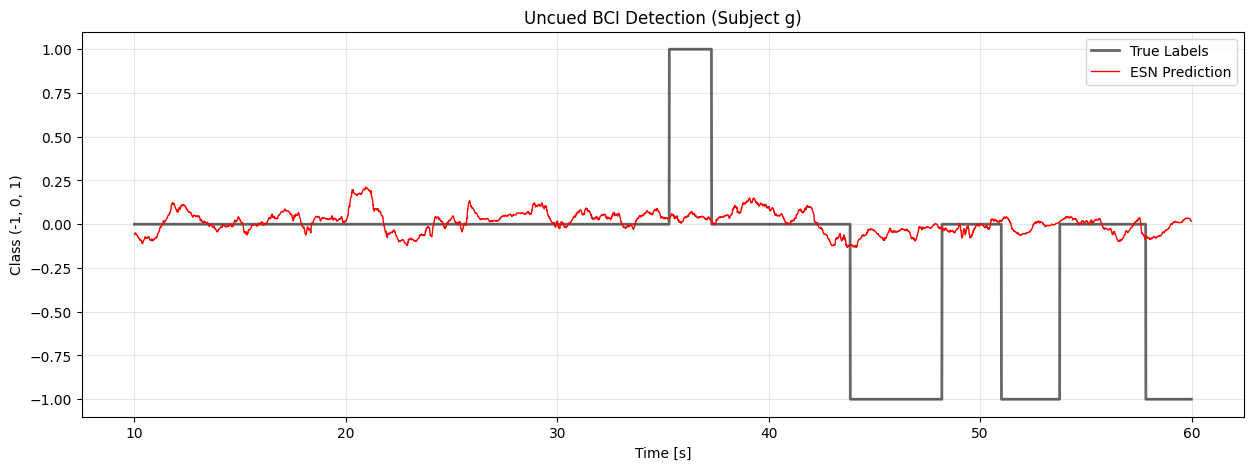

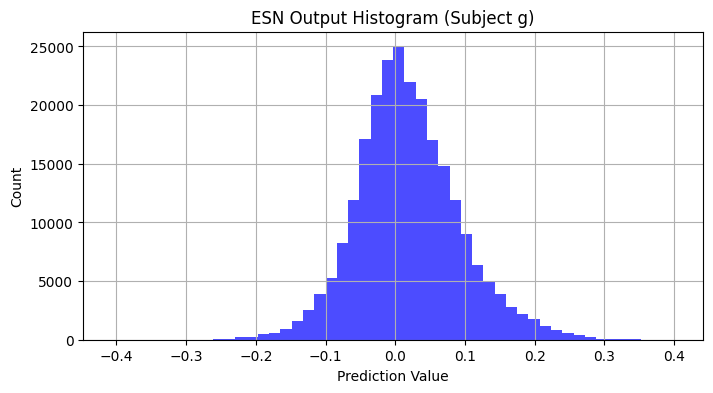

In [15]:
for subject in subjects:
    print(f"\n--- Evaluating Subject {subject} ---")
    
    data = subject_test_data[subject]
    X_test_feats = data['X_test_feats']
    y_test = np.nan_to_num(data['y_test'], nan=0.0)
    fs = data['fs']

    y_pred_continuous = final_esn.predict(X_test_feats)
    y_pred_continuous = np.nan_to_num(y_pred_continuous, nan=0.0)

    mse = mean_squared_error(y_test, y_pred_continuous)
    print(f"MSE result for subject {subject}: {mse:.4f}")

    plt.figure(figsize=(15, 5))
    samples_to_show = 5000 
    start_sample = 1000
    
    end_sample = min(start_sample + samples_to_show, len(y_test))
    
    if start_sample < end_sample:
        t = np.arange(start_sample, end_sample) / fs
        
        plt.plot(t, y_test[start_sample:end_sample], 'k-', label='True Labels', linewidth=2, alpha=0.6)
        plt.plot(t, y_pred_continuous[start_sample:end_sample], 'r-', label='ESN Prediction', linewidth=1)

        plt.title(f'Uncued BCI Detection (Subject {subject})')
        plt.xlabel('Time [s]')
        plt.ylabel('Class (-1, 0, 1)')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()
    else:
        print(f"Not enough samples to plot for subject {subject}")

    plt.figure(figsize=(8, 4))
    plt.hist(y_pred_continuous, bins=50, color='blue', alpha=0.7)
    plt.title(f'ESN Output Histogram (Subject {subject})')
    plt.xlabel('Prediction Value')
    plt.ylabel('Count')
    plt.grid(True)
    plt.show()